In [59]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#plt.style.use('seaborn-white')
#plt.style.use('fivethirtyeight')


In [ ]:
df = pd.read_csv("data_train.csv")

In [6]:
df.head()

,id,title,desc,job_id
0,3923352,ALT2- Ingénieur Concept°/Dévelopt (H/F) Toulouse,MISSIONS \n \n Au sein du service Maintenance ...,36
1,3326931,Juriste Conseil en Assurance Vie - Spécialiste...,Au sein de la Direction Juridique Assurances d...,10
2,3526811,Directeur d'Agence (H/F) - MONTELIMAR,"Rattaché(e) au Directeur de Secteur, vous pilo...",15
3,4804429,Banque Palatine - CDI - directeur du contentie...,Le Secrétariat Général de la Banque Palatine r...,16
4,2494792,Contrôleur de gestion marché (H/F),En tant que contrôleur de gestion vous contrib...,27


## Visualiser le nombre d'annonce pour chaque métier:

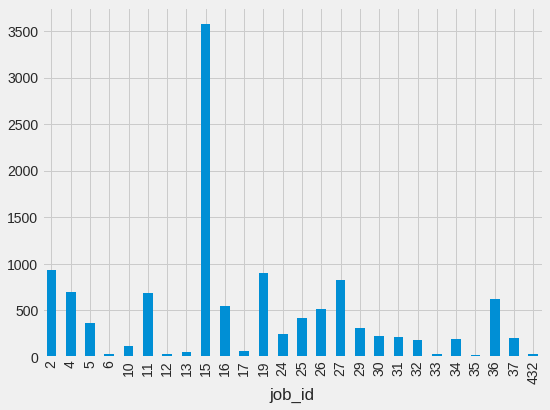

In [21]:
fig = plt.figure(figsize=(8,6))
df.groupby('job_id').title.count().plot.bar(ylim=0)
plt.show()

### Transformation des variables textuelles

In [14]:
from nltk.corpus import stopwords
stpw = set(stopwords.words('french'))

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2'
                        , ngram_range=(1, 2), 
                        stop_words= stpw)

In [16]:
features_1 = tfidf.fit_transform(df.title).toarray()
features_1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
features_1.shape

(12000, 2751)

In [18]:
df.job_id.shape

(12000,)

In [19]:
category_id_df = df[['title', 'job_id']].drop_duplicates().sort_values('job_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['title', 'job_id']].values)
labels = df.job_id

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['job_id'],
                                                    random_state = 0)

In [29]:
X_train.head(3)

9573    Conseiller Financier (H/F) – Eaubonne (95)
9113           Chargé(e) d’Etudes Statistiques H/F
445             Stage - Juriste Droit Social (H/F)
Name: title, dtype: object

In [30]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
#clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier( random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/nabil/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nabil/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/nabil/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nabil/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/nabil/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logisti

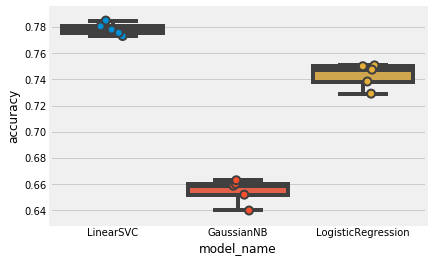

In [51]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [44]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression    0.743181
SVC                   0.298335
Name: accuracy, dtype: float64

In [62]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, 
                                                                                 df.index, test_size=0.33, 
                                                                                 random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

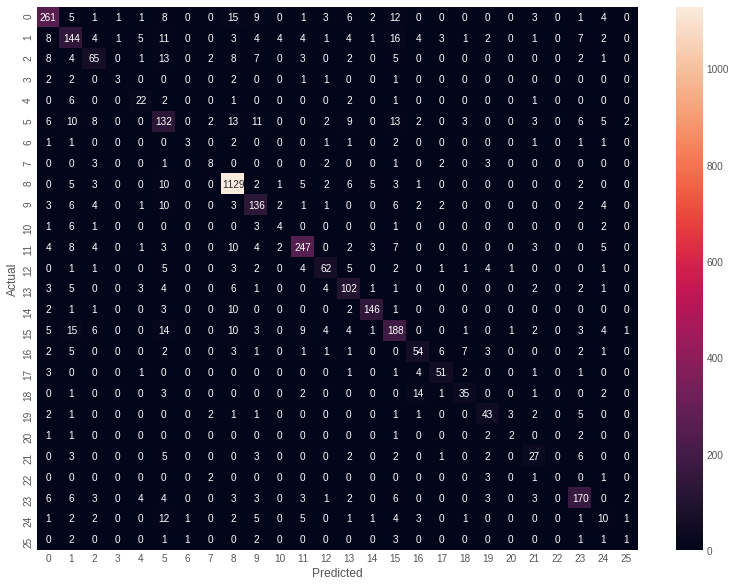

In [61]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [64]:
cv_df


,model_name,fold_idx,accuracy
0,LinearSVC,0,0.773123
1,LinearSVC,1,0.778009
2,LinearSVC,2,0.784910
3,LinearSVC,3,0.775553
4,LinearSVC,4,0.780518
5,GaussianNB,0,0.639983
6,GaussianNB,1,0.658892
7,GaussianNB,2,0.660275
8,GaussianNB,3,0.652065
9,GaussianNB,4,0.663043
